# Generate training batches for the GFS embedding network

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from datetime import datetime, timedelta

sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

**Batch gen 2021**

In [9]:
# ======================================================== #
year = 2021
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(365)]

N_start = 363 #81

LEADs = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] #
INIs = [0, 6, 12, 18]

size = 128 # patch size: 128-by-128
gap = 24 # subset patches with gaps of 24 grids
N_rain_thres = 4000 # each patch must have 4000 raining grid cells
V_rain_thres = 0.1 # 0.1 mm/3h means rain
# ======================================================== #


In [5]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    elev_01 = h5io['elev_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

# ------- normalized elevation ----- #
elev_01[elev_01<0] = 0
elev_01 = elev_01/2000 - 1

In [6]:
# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

grid_shape = (x_mrms, y_mrms)

# ------- Import MRMS data ------- #
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'.format(year), 'r') as h5io:
    MRMS_base = h5io['MRMS'][...]
L_base = len(MRMS_base)

# forecast lead times can exceed one year
N_beyond = 5*24
N_total = L_base + N_beyond
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'.format(year+1), 'r') as h5io:
    MRMS_extra = h5io['MRMS'][:N_beyond, ...]

MRMS = np.concatenate((MRMS_base, MRMS_extra), axis=0)

In [10]:
# ------- file locations and names ------ #
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/'
batch_file_name = 'GFS_y{:04d}_ini{:02d}_lead{:02d}_dt{:04d}_ix{:03d}_iy{:03d}.npy'

name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'

# data allocations
data = np.empty((1, x_mrms, y_mrms, 9))
data[...] = np.nan

gfs = np.empty((1, x_gfs, y_gfs, 7))
gfs[...] = np.nan

for lead in LEADs:
    for ini in INIs:

        with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
            CAPE = h5io['CAPE'][...]
            PWAT = h5io['PWAT'][...]
            T800 = h5io['T800'][...]
            U800 = h5io['U800'][...]
            V800 = h5io['V800'][...]
            RH800 = h5io['RH800'][...]
        
        with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
            APCP = h5io['APCP'][...]

        # ======================================================== #
        for i_dt, dt in enumerate(date_list):

            # N_start = 0 means full run
            # N_start = 363 for small tests
            if i_dt >= N_start:
                
                # get the forecasted hour (ini + lead)
                N_hours = i_dt*24 + ini + lead
                
                # combine hourly MRMS to 3-hr accumulated values
                if N_hours < N_total:
                    MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
    
                    # downsample to GFS resolution (not used)
                    # hr_to_lr = RegularGridInterpolator((lat_01[:, 0], lon_01[0, :]), MRMS_temp, 
                    #                                    bounds_error=False, fill_value=None)
                    # MRMS_lr = hr_to_lr((lat_GFS, lon_GFS))
                    
                    #gfs[..., 0] = MRMS_lr
                    gfs[..., 0] = APCP[i_dt, ...]
                    gfs[..., 1] = CAPE[i_dt, ...]
                    gfs[..., 2] = PWAT[i_dt, ...]
                    gfs[..., 3] = T800[i_dt, ...]
                    gfs[..., 4] = U800[i_dt, ...]
                    gfs[..., 5] = V800[i_dt, ...]
                    gfs[..., 6] = RH800[i_dt, ...]
    
                    # collect batch data
                    # index 0: MRMS target
                    data[..., 0] = MRMS_temp
    
                    # index 1-7: GFS interpolated to 0.1 deg
                    for i in range(7):
                        lr_to_hr = RegularGridInterpolator((lat_GFS[:, 0], lon_GFS[0, :]), gfs[0, ..., i], 
                                                           bounds_error=False, fill_value=None)
                        data[..., i+1] = lr_to_hr((lat_01, lon_01))
    
                    # convert negative MRMS to zero
                    # 
                    temp = data[..., 0]
                    temp[temp < 0] = 0
                    data[..., 0] = temp
    
                    # data normalization
                    data[..., 0] = norm_precip(data[..., 0]) # MRMS
                    data[..., 1] = norm_precip(data[..., 1]) # GFS APCCP
                    data[..., 2] = norm_cape(data[..., 2]) # GFS CAPE
                    data[..., 3] = norm_pwat(data[..., 3]) # PWAT
                    data[..., 4] = norm_t(data[..., 4]) # T800
                    data[..., 5] = norm_u(data[..., 5]) # U800
                    data[..., 6] = norm_v(data[..., 6]) # V800
                    data[..., 7] = norm_rh(data[..., 7]) # RH800
    
                    # index 8: elevation
                    data[..., 8] = elev_01 # normalized elevatino
    
                    # subset patches from the 0.1 deg MRMS domain
                    for ix in range(0, grid_shape[0]+gap, gap):
                        for iy in range(0, grid_shape[1]+gap, gap):
                            
                            # index ranges
                            ix_start = ix; ix_end = ix+size
                            iy_start = iy; iy_end = iy+size
                            
                            # if not at the edge
                            if (ix_end < grid_shape[0]) and (iy_end < grid_shape[1]):
                                temp_mrms_flag = data[0, ix_start:ix_end, iy_start:iy_end, 0]
                                
                                # if the patch contains enough raining grid cells
                                if np.sum(temp_mrms_flag > V_rain_thres) > N_rain_thres:
    
                                    # if the patch doesn't have NaNs 
                                    if np.sum(np.isnan(data)) == 0:
                                        
                                        # save as .npy
                                        name_ = BATCH_dir+batch_file_name.format(year, ini, lead, N_hours, ix, iy)
                                        print(name_)
                                        np.save(name_, data[:, ix_start:ix_end, iy_start:iy_end, :])

/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix024_iy312.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix024_iy336.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix024_iy360.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix024_iy384.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix048_iy288.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix048_iy312.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix048_iy336.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix048_iy360.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix048_iy384.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix072_iy288.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini00_lead03_dt0363_ix07

### Check batch quality

In [26]:
temp = np.load(
    '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/GFS_y2021_ini18_lead36_dt8790_ix120_iy432.npy')

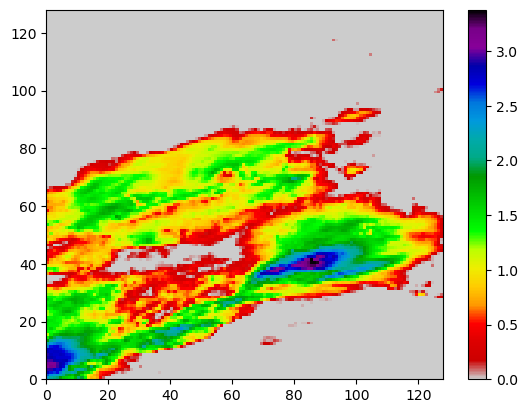

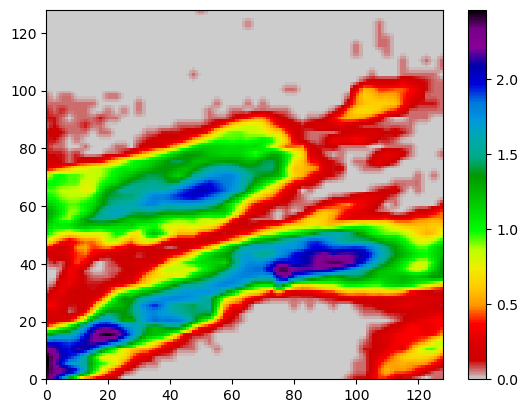

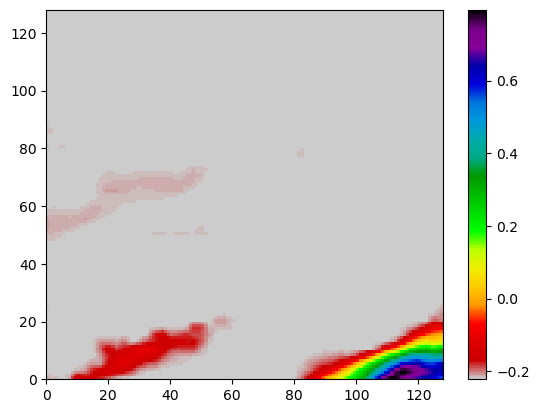

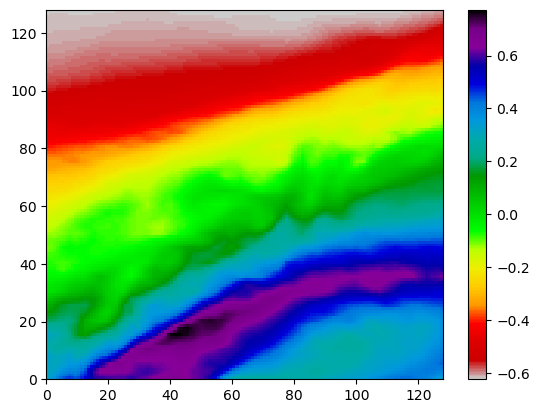

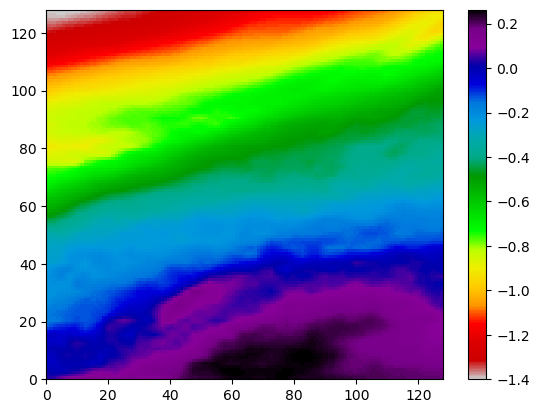

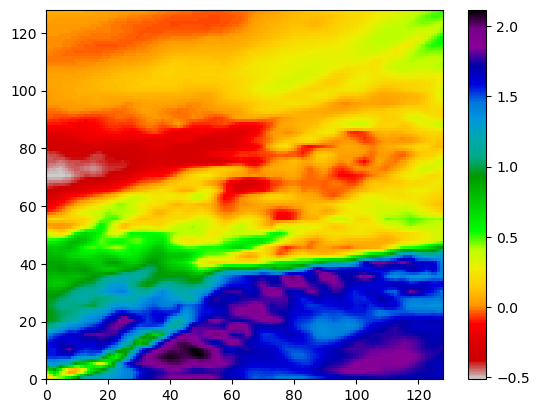

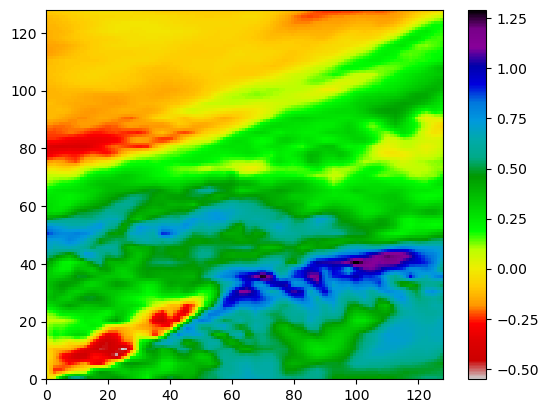

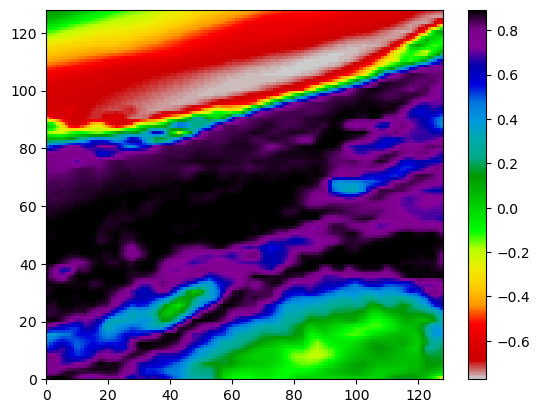

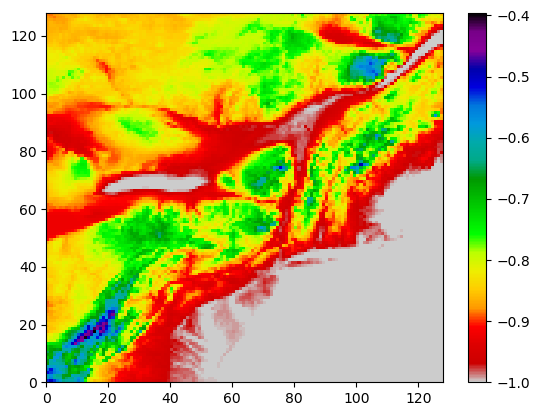

In [27]:
for i in range(9):
    plt.figure()
    plt.pcolormesh(temp[0, ..., i], cmap=plt.cm.nipy_spectral_r)
    plt.colorbar()